In [1]:
from __future__ import print_function

import ufl
from fenics import BoxMesh, Point, DirichletBC, FacetNormal, RectangleMesh
from fenics import FunctionSpace, VectorFunctionSpace
from fenics import TrialFunction, TestFunction
from fenics import Expression, Function, Constant
from fenics import dot, inner, Identity, sym
from fenics import grad, nabla_grad, tr
from ufl import nabla_div
from fenics import sqrt
from fenics import project
from fenics import dX, dS
from fenics import dx, ds
from fenics import solve, interpolate
from fenics import plot
from fenics import File
from fenics import lhs, rhs, assemble
from fenics import Mesh
from dolfin import near, SubDomain
# from dolfin import *
from fenics import TensorFunctionSpace
from fenics import TensorElement, FiniteElement, VectorElement
from fenics import cells
from ufl import Coefficient
import ufl
from ufl import triangle

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Попытка сделать аналогично учебнику (неудачно)

In [3]:
dH = 0.012
dW = 0.02

In [4]:
mu1 = Constant(0.8e11)
mu2 = Constant(0.5e11)
lambda1 = Constant(1.25e11)
lambda2 = Constant(0.65e11)
k1 = Constant(200.)
k2 = Constant(100.)
beta1 = Constant(6.0e-6)
beta2 = Constant(3.0e-6)
alphaAir = Constant(50.)
TAir = Constant(20.)
THot = Constant(150.)
T0 = Constant(40.)
eo = 1

In [5]:
mesh = Mesh('../mesh/composite.xml')

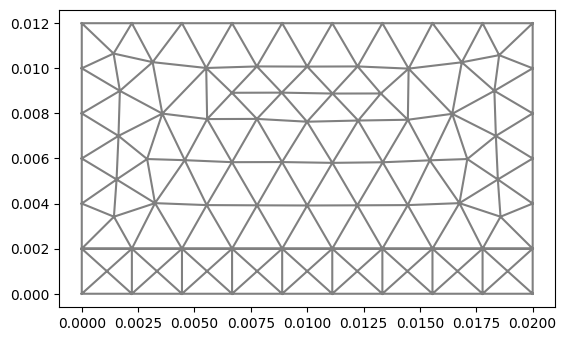

In [6]:
plot(mesh)

In [7]:
mesh.ufl_cell()

triangle

In [8]:
mesh.ufl_coordinate_element()

VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)

In [9]:
# ufl.FiniteElement.shortstr()

In [10]:
mesh.cells()

array([[53, 61, 80],
       [54, 67, 76],
       [54, 70, 76],
       [53, 72, 80],
       [61, 63, 80],
       [66, 67, 76],
       [62, 68, 73],
       [58, 61, 63],
       [55, 64, 66],
       [30, 53, 72],
       [13, 56, 57],
       [18, 55, 64],
       [56, 57, 63],
       [64, 65, 66],
       [65, 66, 67],
       [25, 54, 70],
       [12, 13, 56],
       [18, 19, 55],
       [57, 58, 63],
       [30, 31, 72],
       [25, 26, 54],
       [29, 30, 53],
       [24, 25, 70],
       [58, 60, 61],
       [27, 50, 69],
       [28, 50, 71],
       [59, 62, 73],
       [13, 14, 57],
       [17, 18, 64],
       [14, 52, 57],
       [17, 51, 64],
       [26, 54, 69],
       [29, 53, 71],
       [52, 57, 58],
       [51, 64, 65],
       [59, 73, 74],
       [65, 68, 73],
       [58, 59, 60],
       [16, 51, 74],
       [15, 16, 74],
       [26, 27, 69],
       [28, 29, 71],
       [14, 15, 52],
       [16, 17, 51],
       [27, 28, 50],
       [51, 73, 74],
       [52, 58, 59],
       [15, 5

In [11]:
cell = mesh.ufl_cell()
cell

triangle

In [12]:
# Create functional space
PT = FiniteElement('P',mesh.ufl_cell(), degree=eo)  # piecewise linear polynomials
PU = VectorElement('P',mesh.ufl_cell(), degree=eo)
PS = TensorElement('P',mesh.ufl_cell(), degree=eo)
# PS = TensorElement('Lagrange',cell=cell ,degree=eo)


PT = FunctionSpace(mesh,PT)
PU = VectorFunctionSpace(mesh,'P', degree=eo)
# PS = TensorFunctionSpace(mesh,PS, degree=eo)



In [13]:

# Create 'trial function' (the unknown function to be approximated) over the space PT
T = TrialFunction(PT)  # scalar temperature field, such that: T(x,y) = Sum(tem_i* w(x,y))
d1 = T.geometric_dimension()  # space dimension
u = TrialFunction(PU)  # vector displacement field
d2 = u.geometric_dimension()  # space dimension


In [14]:
# Create scalar 'test function' (or 'shape function', or 'weighting function') over the space PT
q = TestFunction(PT)  # q -> T
v = TestFunction(PU)  # v -> u

t = 0
# Define expressions used in variational forms to prevent repeated code generation
n = FacetNormal(mesh)  # per-face normal vector
# k_ = Constant(k / (rho * Cp))  # thermal conductivity
Traction = Constant((0, 0))  # traction


In [15]:
F_T = inner(k1 * nabla_grad(T),nabla_grad(q)) * dx + inner(k2*nabla_grad(T), nabla_grad(q)) * dx - alphaAir*(T-TAir) * q * ds

a_T = lhs(F_T)
L_T = rhs(F_T)

In [16]:

tem_surf = '(300 + ' \
           '500 * exp(-pow( (t-5)/dt, 2)) * ' \
           '( (( pow((x[0] - dW/2)/r, 2) + pow((x[2] - dD/2)/r, 2) ) <= 1.0) ? 1.0 : 0.0))'
tem_desired = Expression('2000', degree=eo)
fact_ = Constant(1.0e19)

# Problem settings
tem_0 = Constant(300)  # [K] initial temperature
tem_ref = tem_0  # [K] reference temperature


In [17]:
temp = Coefficient(PT)

In [18]:
I = Identity(v.geometric_dimension())

# Define strains and stress
def epsilon(v):
    return 0.5 * (nabla_grad(v) + nabla_grad(v).T)
    # return sym(nabla_grad(u))


# def epsilon_therm(T):
#     return alpha * (T - tem_ref) * Identity(d1)
#
#
# def sigma(u):
#     return lambda_ * nabla_div(u) * Identity(d2) + 2 * mu * epsilon(u) \
#         - (3 * lambda_ + 2 * mu) * epsilon_therm(T)

# T its T, T0 its tem_ref
def sigma(v, mu, lmbda, T, beta):
    alpha = beta * (lmbda + 2 *mu/3)
    return 2*mu*epsilon(v) + lmbda*tr(epsilon(v))*Identity(d2) - alpha * (T - TAir) * Identity(d1)


In [19]:
tem_0 = Expression('300', degree=eo)
tem_n = project(tem_0, PT, solver_type="cg", preconditioner_type="amg")

In [20]:
F_u = inner(sigma(u,mu1,lambda1,tem_n,beta1), epsilon(v)) * dx + inner(sigma(u,mu2,lambda2,tem_n,beta2),epsilon(v)) * dx

In [21]:
# stress = TrialFunction(PS)
# w = TestFunction(PS)
# disp = Coefficient(PU)
#
# F_s = inner(stress, w) * dx - inner(sigma(u,mu1,lambda1,temp,beta1), epsilon(v)) * dx(1) - inner(sigma(u,mu2,lambda2,temp,beta2),epsilon(v)) * dx(2)



a_u = lhs(F_u)
L_u = rhs(F_u)

# a_s = lhs(F_s)
# L_s = rhs(F_s)

forms = [a_T,L_T, a_u, L_u]

In [22]:

# Compute boundary surfaces of the mesh (via C++ wrapper)

tol = 1E-14


# https://fenicsproject.org/olddocs/dolfin/1.3.0/python/demo/documented/subdomains-poisson/python/documentation.html
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)


class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], dH)


In [23]:

# bottom surfcae
# bs_bottom_wall = 'near(x[1], 0.0)'
# bs_bottom_wall = near(x[1],0.0)
bs_bottom_wall = Bottom()
# bs_top_wall = 'near(x[1],dH)'
# bs_top_wall = near(x[1],dH)
bs_top_wall = Top()

bs_top_edges = [Point(0.0, dH), Point(dW, dH)]


# bs_top_edges = Point(0.0, dH)

def upper_left_fixed_point(x, on_boundary):
    tol = 1E-15
    return (near(x[0], 0.0) and near(x[1],dH))

# def upper_left_fixed_point(x, on_boundary):
#     tol = 1E-15
#     return Point(0.0, dH)


def upper_right_fixed_point(x, on_boundary):
    tol = 1E-15
    return (near(x[0], dW) and near(x[1],dH))


# BC at the bottom
bc_tem_bottom = DirichletBC(PT,TAir, bs_bottom_wall)
bc_tem_top = DirichletBC(PT, THot, bs_top_wall)
bcs_tem = [bc_tem_bottom, bc_tem_top]
# bc_u_bottom = DirichletBC(PU.sub(0), Constant((0,0)), bs_top_edges)
#
bc_top_right_fixed_point = DirichletBC(PU.sub(1), Constant(0.0), upper_right_fixed_point, method='pointwise')
# bc_top_right_fixed_point = DirichletBC(PU, Constant(0.0), upper_right_fixed_point, method='pointwise')

bc_top_left_fixed_point = DirichletBC(PU.sub(0), Constant(0.0), upper_left_fixed_point, method='pointwise')
#
bcs_u = [bc_top_left_fixed_point, bc_top_right_fixed_point]
# bcs_u = [bc_u_bottom]

In [24]:
# Compose weak form of PDE(heat):

# T = TrialFunction(PT)
# q = TestFunction(PT)

In [25]:
# eq_tem = (k_ * inner(nabla_grad(T), nabla_grad(q)) * dX - (tem_desired - T) * fact_ * q * dX)
# a_therm = lhs(eq_tem)
# L_therm = rhs(eq_tem)


In [26]:
# Compose weak form of PDE(elasticity):
# Split the equation into right-hand-side (RHS) and left-hand-side (LHS) parts:
u = TrialFunction(PU)
v = TestFunction(PU)
# sigma_ = lambda_ * nabla_div(u) * Identity(d2) + mu * (nabla_grad(u) + nabla_grad(u).T) \
#          - (3 * lambda_ + 2 * mu) * alpha * (tem_n - tem_ref) * Identity(d1)
# epsilon_ = 0.5 * (nabla_grad(v) + nabla_grad(v).T)
# elastic_eqn = inner(sigma_, epsilon_) * dX - dot(Traction, v) * ds
# LHS, bilinear form
# a_elas = lhs(elastic_eqn)
# RHS, Linear form
# L_elas = rhs(elastic_eqn)


In [27]:
# Prepare export to file
path = 'results/'
tem_file = File(f'{path}T.pvd')
u_file = File(f'{path}u.pvd')
vms_file = File(f'{path}vms.pvd')


In [28]:
# Time loop
T = Function(PT)
u = Function(PU)

print(f'DOFs = {PU.dim() + PT.dim()}')


DOFs = 300


In [29]:
# Update time value in expression
# tem_desired.t = t

sol_settings = {'linear_solver': 'mumps'}

# Compute HCE
# solve(a_T == L_T, T, bcs_tem, solver_parameters=sol_settings)
solve(a_T == L_T,T, bcs=bcs_tem, solver_parameters=sol_settings)

# Update previous solution
tem_n.assign(T)

# Compute elasticity
solve(a_u == L_u, u, bcs= bcs_u, solver_parameters=sol_settings)


Solving linear variational problem.
Solving linear variational problem.


F_u = inner(sigma(u,mu1,lambda1,tem_n,beta1), epsilon(v)) * dx + inner(sigma(u,mu2,lambda2,tem_n,beta2),epsilon(v)) * dx


PS = TensorElement('P',mesh.ufl_cell(), degree=eo)
# PS = TensorElement('Lagrange',cell=cell ,degree=eo)
PS = TensorFunctionSpace(mesh,'P', degree=eo)


stress = TrialFunction(PS)
w = TestFunction(PS)
# disp = Coefficient(PU)
disp = u


# disp = project(disp,PU)

# disp= project(disp,PT)
#
F_s = inner(stress, w) * dx - inner(sigma(disp,mu1,lambda1,tem_n,beta1), w) * dx(1) - inner(sigma(disp,mu2,lambda2,tem_n,beta2),w) * dx(2)


a_s , L_s = ufl.system(F_s)
# a_s = lhs(F_s)
# L_s = rhs(F_s)



w = Function(PS)
solve(a_s==L_s,u)

In [30]:
# Compute stress
s = sigma(u,mu1,lambda1,tem_n,beta1) - (1. / 3) * tr(sigma(u,mu1,lambda1,tem_n,beta1)) * Identity(d2)  # deviatoric stress
von_Mises = sqrt(3. / 2 * inner(s, s))
von_Mises = project(von_Mises, PT)


In [31]:
# Save solution
T.rename('T [K]', 'label')
tem_file << (T, t)
u.rename('U [m]', 'label')
u_file << (u, t)
von_Mises.rename('VMS [Pa]', 'label')
vms_file << (von_Mises, t)

print(f'{t}')
# print(PT'{t} / {dt*num_steps}')


0


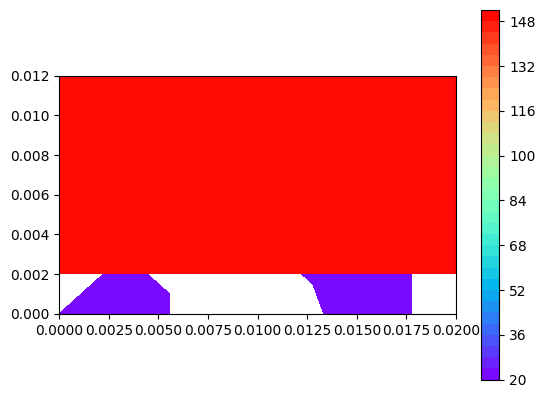

In [32]:
from matplotlib import cm
fig = plot(T,mesh)
fig.set_cmap(cm.rainbow)

# gr = fig.axes.pcolor(tem.vector())
plt.colorbar(fig)
plt.show()